In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# general settings
device = torch.device('cuda' if use_gpu else 'cpu')
print('device:', device)

# batchsize
batchsize = 100

# random seed
seed = 1
torch.manual_seed(seed)

if use_gpu:
    torch.cuda.manual_seed(seed)

device: cuda


In [3]:
# random erasing transform
class RandomErasing(object):
    def __init__(self, erasing_prob, erasing_height = 4, erasing_width = 4):
        self.erasing_prob = erasing_prob
        self.erasing_height = erasing_height
        self.erasing_width = erasing_width
        
    def __call__(self, sample):
        if np.random.rand() < self.erasing_prob:
            return self.random_erase(sample) # anomaly samples have negative label (use abs if you wanna see number)
        else:
            return sample
            
    def random_erase(self, tensor):
        channel, height, width = tensor.size()
        erasing_h = np.random.randint(height - self.erasing_height)
        erasing_h = [erasing_h, erasing_h + self.erasing_height]
        erasing_w = np.random.randint(width - self.erasing_width)
        erasing_w = [erasing_w, erasing_w + self.erasing_width]
        tensor[:, \
               erasing_h[0]:erasing_h[1], \
               erasing_w[0]:erasing_w[1]] = torch.ones(self.erasing_height, self.erasing_width)   
        
        return tensor

In [4]:
# compose transforms (convert to PyTorch Tensor, Normalize, and random erasing(train:0.01,test:0.5 samples contaminated))
tf_train = transforms.Compose([transforms.ToTensor(), 
                               RandomErasing(erasing_prob = 0.01),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# anomaly for test data will be added after
tf_test = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# using SVHN dataset
training_data = datasets.SVHN(root = '../../data', split = 'train', transform = tf_train, download = True)
test_data = datasets.SVHN(root = '../../data', split = 'test', transform = tf_test, download = True)

Using downloaded and verified file: ../../data/train_32x32.mat
Using downloaded and verified file: ../../data/test_32x32.mat


In [5]:
# split to training data and validation data
train_data, validation_data = train_test_split(training_data, test_size = 0.2, random_state = seed)
print('The number of training data:', len(train_data))
print('The number of validation data', len(validation_data))

The number of training data: 58605
The number of validation data 14652


In [6]:
# prepare data loader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = False)

In [7]:
# define downsampling parts for convenience
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Downsampler, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.cv(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [8]:
# define upsampling parts for convenience
class Upsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Upsampler, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.tc(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [9]:
# define VAE Encoder
class Encoder(nn.Module):
    def __init__(self, n_z):
        super(Encoder, self).__init__()
        self.cv1 = Downsampler(  3,  32) # out tensor size : (batchsize,  32, 16, 16)
        self.cv2 = Downsampler( 32,  64) # out tensor size : (batchsize,  64,  8, 8)
        self.cv3 = Downsampler( 64, 128) # out tensor size : (batchsize, 128,  4, 4)
        self.cv4 = Downsampler(128, 256) # out tensor size : (batchsize, 256,  2, 2)
        
        self.fc5_mean   = nn.Linear(256*2*2, n_z)
        self.fc5_logvar = nn.Linear(256*2*2, n_z)
    
    def forward(self, x):
        out = self.cv1(x)
        out = self.cv2(out)
        out = self.cv3(out)
        out = self.cv4(out)
        
        out = out.view(out.size(0), -1)
        
        out_mean   = self.fc5_mean(out)
        out_logvar = self.fc5_logvar(out)
        
        return out_mean, out_logvar

In [29]:
# define VAE Decoder
class Decoder(nn.Module):
    def __init__(self, n_z):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_z, 256*2*2)
        self.tc2 = Upsampler(256, 128)   # out tensor size : (batchsize, 256,  4,  4)
        self.tc3 = Upsampler(128,  64)   # out tensor size : (batchsize, 128,  8,  8)
        self.tc4 = Upsampler( 64,  32)   # out tensor size : (batchsize,  64, 16, 16)
        self.tc5_mean    = nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1) # (batchsize, 3, 32, 32)
        self.tc5_logvar  = nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1) # (batchsize, 3, 32, 32)
    
    def forward(self, x):
        out = self.fc1(x)
        
        out = out.view(out.size(0), 256, 2, 2)
        
        out = self.tc2(out)
        out = self.tc3(out)
        out = self.tc4(out)
        out_mean = self.tc5_mean(out)
        out_logvar  = self.tc5_logvar(out)
        
        return out_mean, out_logvar

In [30]:
# define VAE
class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        self.encoder = Encoder(n_z)
        self.decoder = Decoder(n_z)
    
    def forward(self, x):
        embed_mean, embed_logvar = self.encoder(x)
        
        eps = torch.randn(embed_mean.size()).to(device)
        z = (0.5 * embed_logvar).exp() * eps + embed_mean
        
        out_mean, out_logvar = self.decoder(z)
        
        return out_mean, out_logvar, embed_mean, embed_logvar

In [31]:
# prepare network and optimizer
n_z = 500
net = VAE(n_z)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0001)
                       
# counting trainable parameters in model
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
                       
# モデルの構造、オプティマイザの表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 2921006

Model:
 VAE(
  (encoder): Encoder(
    (cv1): Downsampler(
      (cv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (cv2): Downsampler(
      (cv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (cv3): Downsampler(
      (cv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (cv4): Downsampler(
      (cv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (fc5_mean): Linear(in_features=1024,

In [32]:
# define loss functions
def loss_D(embed_mean, embed_logvar):
    loss_d = 0.5 * torch.sum(-embed_logvar - 1 + embed_logvar.exp() + embed_mean.pow(2))
    return loss_d

def loss_A(out_logvar):
    log2pi = float(np.log(2*np.pi))
    loss_a = 0.5 * torch.sum(log2pi + out_logvar)
    return loss_a
    
def loss_M(out_mean, out_logvar, in_x):
    loss_m = 0.5 * torch.sum( (out_mean - in_x).pow(2) / out_logvar.exp() )
    return loss_m

In [33]:
# the function run training for 1 epoch
def train(train_loader):
    net.train()
    
    running_D_loss = 0
    running_A_loss = 0
    running_M_loss = 0
    
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        out_mean, out_logvar, embed_mean, embed_logvar = net(inputs)
        loss_d = loss_D(embed_mean, embed_logvar)
        loss_a = loss_A(out_logvar)
        loss_m = loss_M(out_mean, out_logvar, inputs)
        loss = loss_d + loss_a + loss_m
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_D_loss += loss_d.item()
        running_A_loss += loss_a.item()
        running_M_loss += loss_m.item()
        
    average_D_loss = running_D_loss / len(train_loader.dataset)
    average_A_loss = running_A_loss / len(train_loader.dataset)
    average_M_loss = running_M_loss / len(train_loader.dataset)
    
    return average_D_loss, average_A_loss, average_M_loss

In [34]:
def validation(validation_loader):
    net.eval()
    
    running_D_loss = 0
    running_A_loss = 0
    running_M_loss = 0
    
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            out_mean, out_logvar, embed_mean, embed_logvar = net(inputs)
            loss_d = loss_D(embed_mean, embed_logvar)
            loss_a = loss_A(out_logvar)
            loss_m = loss_M(out_mean, out_logvar, inputs)
            
            running_D_loss += loss_d.item()
            running_A_loss += loss_a.item()
            running_M_loss += loss_m.item()
            
    average_D_loss = running_D_loss / len(validation_loader.dataset)
    average_A_loss = running_A_loss / len(validation_loader.dataset)
    average_M_loss = running_M_loss / len(validation_loader.dataset)
    
    return average_D_loss, average_A_loss, average_M_loss

In [35]:
# run training and save trained model
output_dir = '../../data/VAE_anomaly/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
n_epochs = 30
train_loss_list = [[],[],[]]
validation_loss_list = [[],[],[]]
for epoch in range(n_epochs):
    train_D_loss, train_A_loss, train_M_loss = train(train_loader)
    validation_D_loss, validation_A_loss, validation_M_loss = validation(validation_loader)
    
    train_loss_list[0].append(train_D_loss)
    train_loss_list[1].append(train_A_loss)
    train_loss_list[2].append(train_M_loss)

    validation_loss_list[0].append(validation_D_loss)
    validation_loss_list[1].append(validation_A_loss)
    validation_loss_list[2].append(validation_M_loss)
   
    train_loss = train_D_loss + train_A_loss + train_M_loss
    validation_loss = validation_D_loss + validation_A_loss + validation_M_loss
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' %(epoch+1, n_epochs, train_loss, validation_loss))
    
np.save(output_dir + 'train_loss_list.npy', np.array(train_loss_list))
np.save(output_dir + 'validation_loss_list.npy', np.array(validation_loss_list))

torch.save(net.state_dict(), output_dir + 'VAE_toy.pth')

epoch[1/30] train_loss:-560.8796 validation_loss:-1544.0490
epoch[2/30] train_loss:-1600.5489 validation_loss:-1940.8553
epoch[3/30] train_loss:-2039.2479 validation_loss:-2232.1842
epoch[4/30] train_loss:-2260.0927 validation_loss:-2442.0905
epoch[5/30] train_loss:-2574.2879 validation_loss:-2549.2544
epoch[6/30] train_loss:-2751.2792 validation_loss:-3052.1504
epoch[7/30] train_loss:-2911.3294 validation_loss:-3035.3344
epoch[8/30] train_loss:-3086.0212 validation_loss:-2882.6021
epoch[9/30] train_loss:-3237.9418 validation_loss:-3417.9887
epoch[10/30] train_loss:-3314.0450 validation_loss:-3469.7357
epoch[11/30] train_loss:-3383.4392 validation_loss:-3477.4776
epoch[12/30] train_loss:-3523.1053 validation_loss:-3080.0116
epoch[13/30] train_loss:-3579.3254 validation_loss:-3805.5869
epoch[14/30] train_loss:-3627.7441 validation_loss:-3934.6102
epoch[15/30] train_loss:-3742.4674 validation_loss:-3936.3356
epoch[16/30] train_loss:-3794.3275 validation_loss:-3596.8983
epoch[17/30] train

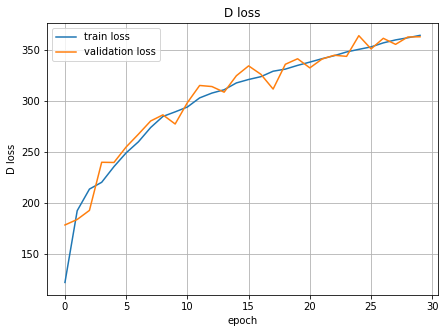

In [40]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[0], label = 'train loss')
plt.plot(validation_loss_list[0], label = 'validation loss')
plt.title('D loss')
plt.xlabel('epoch')
plt.ylabel('D loss')
plt.legend()
plt.grid()
plt.show()

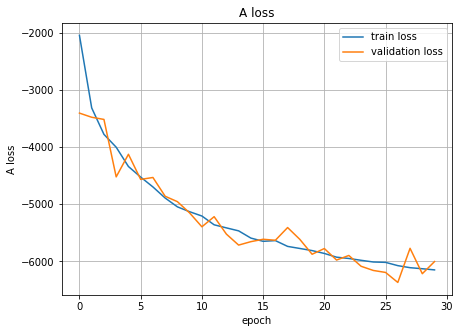

In [41]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[1], label = 'train loss')
plt.plot(validation_loss_list[1], label = 'validation loss')
plt.title('A loss')
plt.xlabel('epoch')
plt.ylabel('A loss')
plt.legend()
plt.grid()
plt.show()

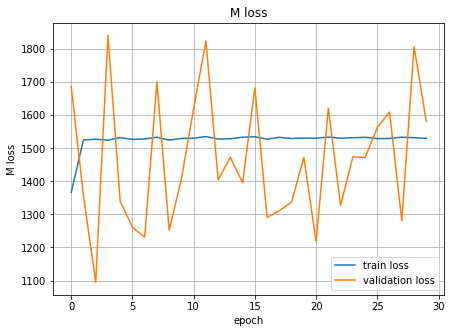

In [44]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[2], label = 'train loss')
plt.plot(validation_loss_list[2], label = 'validation loss')
plt.title('M loss')
plt.xlabel('epoch')
plt.ylabel('M loss')
plt.legend()
plt.grid()
plt.show()

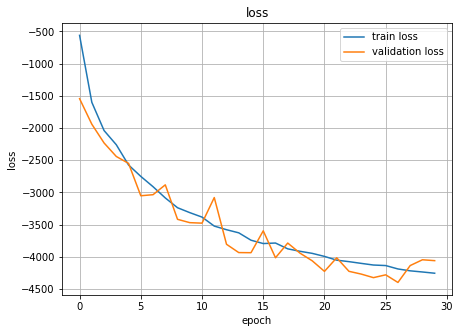

In [47]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(np.sum(train_loss_list, axis = 0), label = 'train loss')
plt.plot(np.sum(validation_loss_list, axis = 0), label = 'validation loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [59]:
def random_erase_for_test(tensor, erasing_height, erasing_width):
    batchsize, channels, height, width = tensor.size()
    
    for b in range(batchsize):
        erasing_h = np.random.randint(height - erasing_height)
        erasing_h = [erasing_h, erasing_h + erasing_height]
        erasing_w = np.random.randint(width - erasing_width)
        erasing_w = [erasing_w, erasing_w + erasing_width]
        tensor[b][:, \
                  erasing_h[0]:erasing_h[1], \
                  erasing_w[0]:erasing_w[1]] = torch.ones(erasing_height, erasing_width)
    return tensor

In [71]:
test_loader = DataLoader(test_data, batch_size = batchsize, shuffle = True)
count = 0
net.eval()
anomaly_loss_list = [[],[],[]]
normal_loss_list = [[],[],[]]
with torch.no_grad():
    for inputs, _ in test_loader:
        isanomaly = (count < len(test_loader.dataset)*0.5)
        if isanomaly:
            inputs = random_erase_for_test(inputs, 4, 4)
        
        inputs = inputs.to(device)
        out_mean, out_logvar, embed_mean, embed_logvar = net(inputs)
        loss_d = loss_D(embed_mean, embed_logvar)
        loss_a = loss_A(out_logvar)
        loss_m = loss_M(out_mean, out_logvar, inputs)
        
        if isanomaly:
            anomaly_loss_list[0].append(loss_d)
            anomaly_loss_list[1].append(loss_a)
            anomaly_loss_list[2].append(loss_m)
        else:
            normal_loss_list[0].append(loss_d)
            normal_loss_list[1].append(loss_a)
            normal_loss_list[2].append(loss_m)
        
        count += len(inputs)
        
anomaly_loss_list = np.array(anomaly_loss_list)
normal_loss_list = np.array(normal_loss_list)

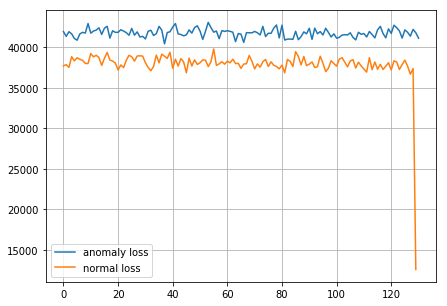

In [72]:
plt.figure(figsize = (7,5))
plt.plot(anomaly_loss_list[0], label = 'anomaly loss')
plt.plot(normal_loss_list[0], label = 'normal loss')
plt.legend()
plt.grid()
plt.show()

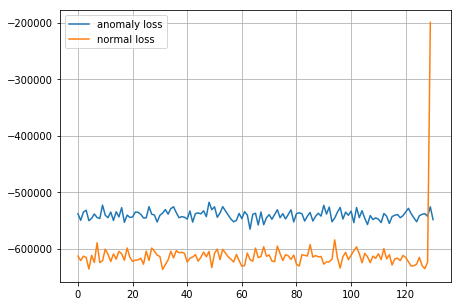

In [73]:
plt.figure(figsize = (7,5))
plt.plot(anomaly_loss_list[1], label = 'anomaly loss')
plt.plot(normal_loss_list[1], label = 'normal loss')
plt.legend()
plt.grid()
plt.show()

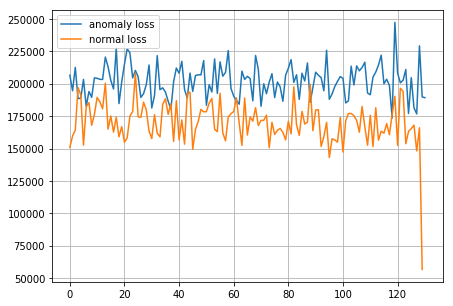

In [74]:
plt.figure(figsize = (7,5))
plt.plot(anomaly_loss_list[2], label = 'anomaly loss')
plt.plot(normal_loss_list[2], label = 'normal loss')
plt.legend()
plt.grid()
plt.show()

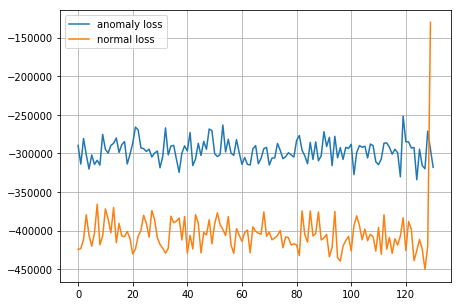

In [75]:
plt.figure(figsize = (7,5))
plt.plot(np.sum(anomaly_loss_list, axis = 0), label = 'anomaly loss')
plt.plot(np.sum(normal_loss_list, axis = 0), label = 'normal loss')
plt.legend()
plt.grid()
plt.show()